<img src = "https://drive.google.com/uc?export=view&id=1VV2e_u46fNm_ewns8QW2HGRZAPHh-e2t" alt = "Encabezado MLDS" width = "100%">  </img>

# Integrantes
+ Ivonne Ruiz
+ David Ovalle
+ Juan Escobar

# **Diseño e implementación experimental**
---

En este proyecto se busca predecir el riesgo crediticio de clientes a partir de un conjunto de datos de préstamos. Para lograrlo, en el presente notebook, el trabajo se dividirá en tres etapas principales.

1) En la primera, se realiza el preprocesamiento de datos, donde se limpian y transforman las variables para que puedan ser interpretadas correctamente por los modelos.
2) En la segunda, se entrena un autoencoder, una red neuronal no supervisada que aprende a reconstruir los datos de entrada y, al hacerlo, genera embeddings, es decir, representaciones numéricas comprimidas que resumen la información más relevante de cada cliente.
3) Finalmente, en la tercera fase, estas representaciones se utilizarán como insumo para probar distintos modelos supervisados de clasificación, con el objetivo de predecir la variable loan_status (cumplimiento o incumplimiento del préstamo).

Este enfoque permite aprovechar la capacidad del autoencoder para descubrir patrones complejos y, al mismo tiempo, evaluar diferentes algoritmos supervisados sobre una base de características más informativa y compacta.

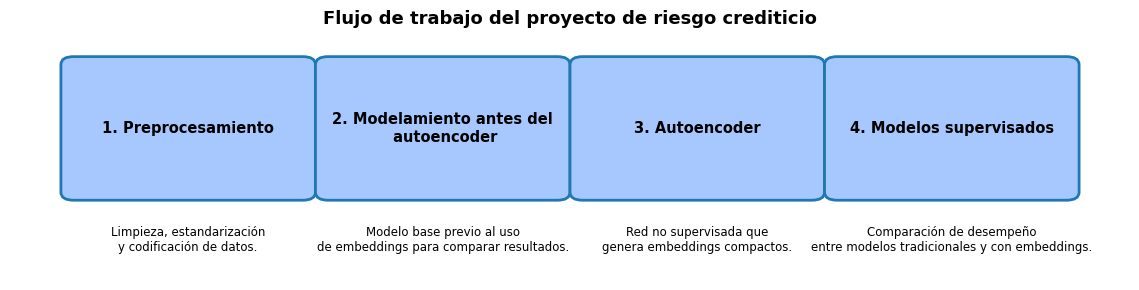

In [ ]:
# @title
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(11.5, 3))

# Etapas
etapas = [
    "1. Preprocesamiento",
    "2. Modelamiento antes del\n autoencoder",
    "3. Autoencoder",
    "4. Modelos supervisados"
]
pos = [1, 2, 3, 4]

# Cuadros
for x, text in zip(pos, etapas):
    rect = mpatches.FancyBboxPatch(
        (x - 0.45, 0.55), 0.9, 0.8,
        boxstyle="round,pad=0.05",
        linewidth=2, edgecolor="#1f77b4", facecolor="#a6c8ff"
    )
    ax.add_patch(rect)
    ax.text(x, 0.95, text, ha='center', va='center', fontsize=10.5, fontweight='bold')

# Descripciones más compactas
ax.text(1, 0.25, "Limpieza, estandarización\ny codificación de datos.",
        ha='center', va='center', fontsize=8.5)

ax.text(2, 0.25, "Modelo base previo al uso\nde embeddings para comparar resultados.",
        ha='center', va='center', fontsize=8.5)

ax.text(3, 0.25, "Red no supervisada que\ngenera embeddings compactos.",
        ha='center', va='center', fontsize=8.5)

ax.text(4, 0.25, "Comparación de desempeño\nentre modelos tradicionales y con embeddings.",
        ha='center', va='center', fontsize=8.5)

# Ajustes visuales
ax.set_xlim(0.3, 4.7)
ax.set_ylim(0, 1.5)
ax.axis('off')

plt.title("Flujo de trabajo del proyecto de riesgo crediticio",
          fontsize=13, fontweight='bold', pad=12)
plt.tight_layout()
plt.show()






## **1. Preprocesamiento y particion del conjunto de datos**
---
En esta primera sección se realiza la limpieza, transformación y preparación del conjunto de datos.
El propósito es dejar la información lista para que el autoencoder pueda aprender correctamente las características de las variables. Para ello, se convierten las categóricas en variables numéricas mediante codificación one-hot, no se aplica preprocesamiento a las variables numéricas dado que este ejercicio fue realizado en la fase anterior.

### 1.1 Importar librerías y cargar los datos

Primero se importan las librerías necesarias y se carga el archivo del conjunto de datos de riesgo crediticio el cual ya tuvo preprocesamiento en la fase anterior. Luego se visualizan las primeras filas para conocer su estructura.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
!wget https://raw.githubusercontent.com/Dovallec/Credit_Risk_Pred/master/df_limpio.csv

--2025-11-06 19:57:52--  https://raw.githubusercontent.com/Dovallec/Credit_Risk_Pred/master/df_limpio.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5083053 (4.8M) [text/plain]
Saving to: ‘df_limpio.csv’

df_limpio.csv       100%[===================>]   4.85M  --.-KB/s    in 0.07s   

2025-11-06 19:57:53 (65.2 MB/s) - ‘df_limpio.csv’ saved [5083053/5083053]



In [ ]:
df = pd.read_csv("df_limpio.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,-1.084249,-1.078678,OWN,0.053786,EDUCATION,B,-1.367672,0.032597,0,-0.655333,N,-0.939103
1,-0.441019,-1.078678,MORTGAGE,-0.936980,MEDICAL,C,-0.657297,0.590925,1,3.766361,N,-0.693013
2,-0.762634,-0.018989,RENT,-0.193905,MEDICAL,C,3.999602,1.352574,1,3.390047,N,-0.939103
3,-0.601827,-0.229410,RENT,0.796861,MEDICAL,C,3.999602,1.042751,1,3.578204,Y,-0.446923
4,-1.084249,-1.072991,OWN,-0.689289,VENTURE,A,-1.130880,-1.258334,1,0.755846,N,-0.939103


### 1.2 Análisis inicial y separación de variables
En esta etapa se identifica la variable objetivo "loan_status" y se separan las variables predictoras (X) de las etiquetas (y).
Se revisan los valores faltantes para entender la estructura de los datos.

In [ ]:
target = "loan_status"
X = df.drop(columns=[target])
y = df[target]

print("Valores nulos por columna:")
print(X.isnull().sum())


Valores nulos por columna:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


Se observa que no hay datos faltantes dado que en la fase anterior se realizó un ejercicio de preprocesamiento para el ajuste de outliers y la imputación de valores nulos.

### 1.3 Identificación de variables numéricas y categóricas
Posteriormente, se identifican las variables numéricas y categóricas.
Esto permite aplicar transformaciones adecuadas a cada tipo de dato en la etapa de preprocesamiento.

In [ ]:
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(exclude=['number']).columns

print("Variables numéricas:", list(num_cols))
print("Variables categóricas:", list(cat_cols))


Variables numéricas: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Variables categóricas: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


### 1.4 Creación del pipeline de preprocesamiento

El flujo de preprocesamiento incluye  la codificación de las categóricas. Para las variables numéricas no es necesario en este punto aplicar alguna transformación adicional dado que se estandarizaron como parte del ejercicio de preprocesamiento realizado en la fase anterior, por esta razón en el transformer se define el parámetro "remainder" con el valor de "passthrough".

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='passthrough'
)

### 1.5 División de datos y aplicación del preprocesamiento

Finalmente, el conjunto de datos preprocesado se divide en entrenamiento, validación y prueba.

Es importante resaltar que el modelo de autoencoder, al ser no supervisado, se entrena únicamente con los datos de entrenamiento, sin utilizar la variable objetivo.



In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

Posteriormente, se aplica el pipeline de preprocesamiento a cada subconjunto.

In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

print("Tamaño del conjunto de entrenamiento:", X_train_prep.shape)

Tamaño del conjunto de entrenamiento: (22065, 26)


### 1.6 Modelo base: Red Densa Multicapa (antes del autoencoder)

Con el objetivo de establecer una línea base previa al uso de embeddings, entrenamos una red densa multicapa directamente sobre las variables preprocesadas (one-hot de categóricas y numéricas en passthrough que fueron preprocesadas y estandarizadas en las fases previas de este proyecto).

Este modelo sirve como referencia experimental para, en secciones posteriores, comparar su desempeño frente a modelos que utilicen los embeddings generados por el autoencoder construido en el numeral siguiente de este notebook. La diferencia entre ambos resultados cuantifica el aporte real del autoencoder a la capacidad predictiva del sistema y resulta un óptimo ejercicio de experimentación y análisis.

En principio, a partir de la matriz de entrenamiento preprocesada, se obtiene el número total de características para definir el tamaño de la capa de entrada. Luego, se calculan los pesos de clase con el fin de balancear la contribución de las observaciones minoritarias y evitar que el modelo favorezca la clase mayoritaria, un problema común en tareas de predicción de incumplimiento crediticio como el que estamos trabajando.

In [ ]:
input_dim = X_train_prep.shape[1]
input_dim

26

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {int(c): w for c, w in zip(classes, weights)}


Posteriormente, se define la arquitectura del modelo baseline, una red neuronal densa multicapa con dos capas ocultas de 32 y 16 neuronas con activación ReLU, una capa Dropout para reducir sobreajuste, y una capa de salida con activación sigmoide, adecuada para clasificación binaria.

In [ ]:
mlp_baseline = keras.Sequential(
    [
        layers.Input(shape=(input_dim,), name="inp"),
        layers.Dense(32, activation="relu", name="h1"),
        layers.Dropout(0.2, name="do1"),
        layers.Dense(16, activation="relu", name="h2"),
        layers.Dense(1, activation="sigmoid", name="out"),
    ],
    name="MLP_Baseline_PreAE",
)


El modelo se compila usando el optimizador Adam con tasa de aprendizaje de 0.001 y la función de pérdida binary crossentropy, incorporando las métricas de exactitud y AUC para monitorear su desempeño.

In [ ]:
mlp_baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.Accuracy(name="accuracy"),
             keras.metrics.AUC(name="auc")]
)


Se implementa early stopping para detener el entrenamiento si la pérdida de validación deja de mejorar durante varias iteraciones, evitando así sobreentrenamiento y conservando los mejores pesos del modelo.

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=6, restore_best_weights=True
)


A continuación, se entrena la red sobre el conjunto de entrenamiento, aplicando los pesos de clase previamente calculados y registrando la evolución de las métricas durante un máximo de 50 épocas.

In [ ]:
history_baseline = mlp_baseline.fit(
    X_train_prep, y_train,
    validation_data=(X_val_prep, y_val),
    epochs=50, batch_size=256,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0000e+00 - auc: 0.6793 - loss: 0.6484 - val_accuracy: 0.0000e+00 - val_auc: 0.8454 - val_loss: 0.5021
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - auc: 0.8439 - loss: 0.4908 - val_accuracy: 0.0000e+00 - val_auc: 0.8664 - val_loss: 0.4608
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - auc: 0.8686 - loss: 0.4519 - val_accuracy: 0.0000e+00 - val_auc: 0.8766 - val_loss: 0.4223
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - auc: 0.8733 - loss: 0.4391 - val_accuracy: 0.0000e+00 - val_auc: 0.8833 - val_loss: 0.4201
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - auc: 0.8797 - loss: 0.4311 - val_accuracy: 0.0000e+00 - val_auc: 0.8880 - val_loss: 0.3991
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - auc: 0.8870 - loss: 0.4193 - val_accuracy: 0.0000e+00 - val_auc: 0.8914 - val_loss: 0.4081
Epoc

Una vez entrenado, el modelo se evalúa sobre los conjuntos de validación y prueba, obteniendo las métricas principales. Después se generan las predicciones de probabilidad sobre el conjunto de prueba y se transforman en etiquetas binarias según un umbral de 0.5. Con estas predicciones se calculan nuevamente las métricas de desempeño mediante scikit-learn, incluyendo el reporte de clasificación que resume precisión, recall y F1-score para cada clase.

In [ ]:
val_metrics = mlp_baseline.evaluate(X_val_prep, y_val, verbose=0)
test_metrics = mlp_baseline.evaluate(X_test_prep, y_test, verbose=0)


NameError: name 'mlp_baseline' is not defined

In [ ]:
y_proba_test = mlp_baseline.predict(X_test_prep, verbose=0).ravel()
y_pred_test = (y_proba_test >= 0.5).astype(int)

test_acc = accuracy_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_proba_test)


In [ ]:
print(f"[VALIDACIÓN] loss={val_metrics[0]:.4f}  acc={val_metrics[1]:.4f}  auc={val_metrics[2]:.4f}")
print(f"[PRUEBA]     loss={test_metrics[0]:.4f}  acc={test_metrics[1]:.4f}  auc(model)={test_metrics[2]:.4f}  "
      f"auc(sklearn)={test_auc:.4f}")

print("\nReporte de clasificación (PRUEBA, umbral=0.5):")
print(classification_report(y_test, y_pred_test, digits=4))


[VALIDACIÓN] loss=0.2934  acc=0.0152  auc=0.9170
[PRUEBA]     loss=0.2919  acc=0.0129  auc(model)=0.9264  auc(sklearn)=0.9263

Reporte de clasificación (PRUEBA, umbral=0.5):
              precision    recall  f1-score   support

           0     0.9342    0.9417    0.9380      3708
           1     0.7820    0.7591    0.7704      1021

    accuracy                         0.9023      4729
   macro avg     0.8581    0.8504    0.8542      4729
weighted avg     0.9013    0.9023    0.9018      4729



El modelo base logró un desempeño sólido tanto en validación como en prueba, con un AUC cercano a 0.92, lo que indica una alta capacidad de discriminación entre clientes cumplidos e incumplidos. La exactitud global fue del 90 %, y las métricas por clase muestran que el modelo clasifica correctamente la mayoría de los casos positivos (recall = 0.76) sin sacrificar excesivamente la precisión (0.79). La clase negativa mantiene un desempeño aún mejor, con un F1 superior a 0.93. Estos resultados reflejan un modelo balanceado y bien generalizado, capaz de capturar relaciones relevantes entre las variables originales. A partir de esta línea base, los próximos experimentos con embeddings del autoencoder permitirán analizar si la representación comprimida de los datos mejora la capacidad predictiva frente a este punto de partida.


## **2. Diseño del Autoencoder**
---

Un autoencoder es una red neuronal que aprende a reconstruir sus propias entradas.
El modelo comprime la información en un espacio latente (embedding) y luego intenta reconstruir los datos originales.
De esta forma, el modelo aprende patrones y relaciones relevantes entre las variables.
Más adelante, los embeddings generados serán usados por otros modelos de predicción del riesgo crediticio.

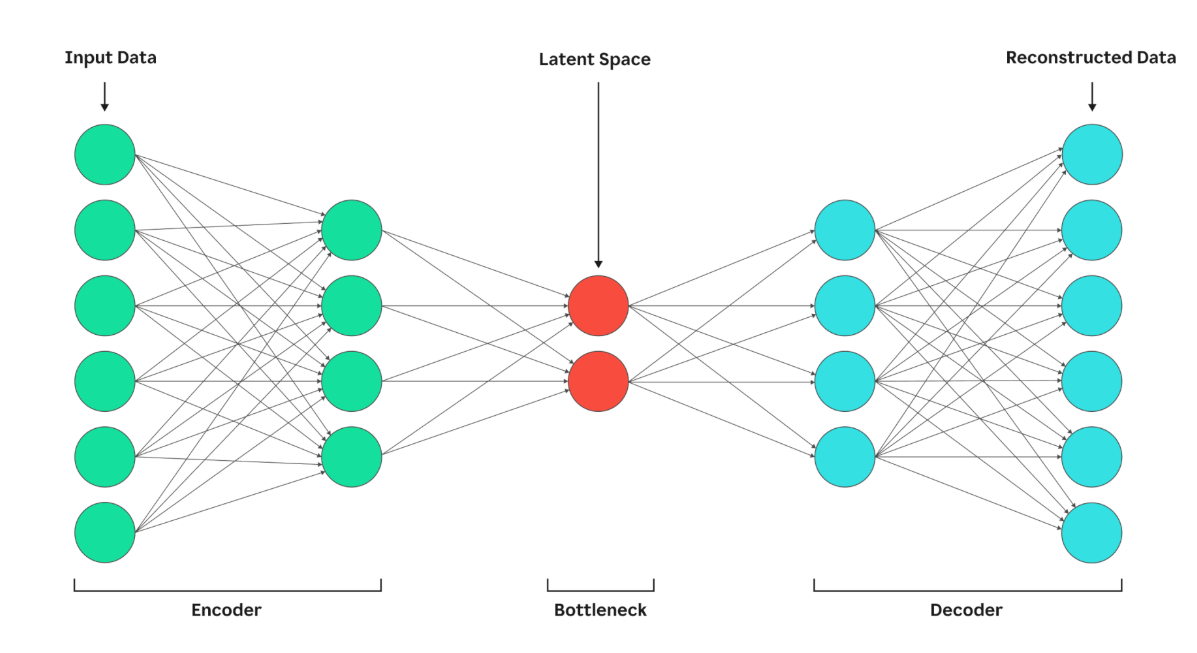

### 2.1 Diseño de la arquitectura

El autoencoder está compuesto por un codificador (encoder) que reduce la dimensionalidad, un espacio latente que representa la información comprimida y un decodificador (decoder) que intenta reconstruir los datos originales.
A continuación, se construye y compila el modelo.

In [ ]:
input_dim = X_train_prep.shape[1]
encoding_dim = 16

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = keras.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,546 (21.66 KB)

 Trainable params: 5,546 (21.66 KB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Entrenamiento del modelo

El modelo se entrena para reconstruir las entradas originales.
Se utiliza un conjunto de validación para monitorear el desempeño y evitar sobreajuste.

Para este caso y considerando las características de nuestra base de datos, la pérdida (loss) será el error cuadrático medio entre las entradas originales y las reconstruidas.

In [ ]:
history = autoencoder.fit(
    X_train_prep, X_train_prep,
    validation_data=(X_val_prep, X_val_prep),
    epochs=50,
    batch_size=128,
    shuffle=True
)


Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3278 - val_loss: 0.0656
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0502 - val_loss: 0.0281
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - val_loss: 0.0211
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - val_loss: 0.0165
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 - val_loss: 0.0137
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0113
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 10/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 11/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 12/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Para comprobar que el autoencoder se entrenó correctamente, se grafican las curvas de pérdida (loss) de entrenamiento y validación.

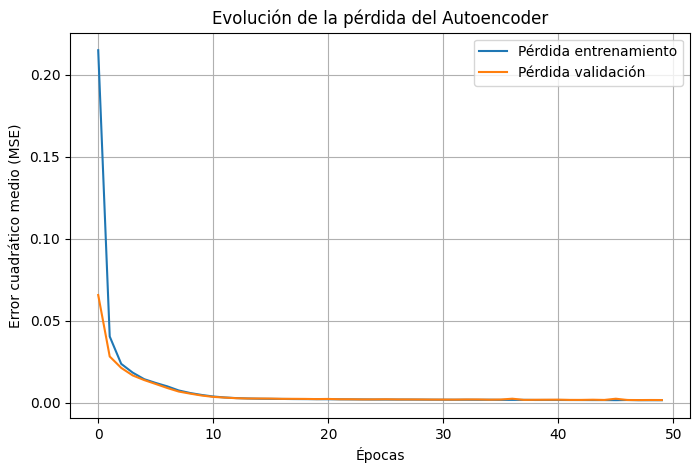

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Evolución de la pérdida del Autoencoder')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio (MSE)')
plt.legend()
plt.grid(True)
plt.show()

La evolución de la pérdida del modelo demuestra un comportamiento estable y convergente. En las primeras épocas, tanto la pérdida de entrenamiento como la de validación disminuyen de manera pronunciada, indicando que el autoencoder aprende rápidamente a reconstruir las entradas. Posteriormente, ambas curvas se estabilizan en valores muy bajos y prácticamente idénticos, lo cual evidencia que el modelo generaliza bien y no presenta sobreajuste. Esto sugiere que la arquitectura seleccionada logra capturar adecuadamente la estructura subyacente de los datos, generando representaciones comprimidas (embeddings) útiles para las etapas posteriores de modelado supervisado.

### 2.3 Obtención de los embeddings
Una vez entrenado el modelo, se extrae únicamente la parte del codificador.
Esto permite transformar cada observación en un vector comprimido que representa sus características más relevantes.

In [ ]:
encoder = keras.Model(inputs=input_layer, outputs=encoded)

Z_train = encoder.predict(X_train_prep)
Z_val = encoder.predict(X_val_prep)
Z_test = encoder.predict(X_test_prep)

print("Dimensiones del espacio latente:", Z_train.shape)


690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Dimensiones del espacio latente: (22065, 16)


### 2.4 Cálculo del error de reconstrucción

El error de reconstrucción indica qué tan bien el modelo logra reproducir los datos originales.
Un error alto significa que la observación tiene un patrón poco común, lo que puede relacionarse con un mayor riesgo crediticio.
Este error se puede usar como una variable adicional en los modelos posteriores razón por la cual se generará en esta fase.

In [ ]:
recon_train = np.mean(np.square(X_train_prep - autoencoder.predict(X_train_prep)), axis=1)
recon_val = np.mean(np.square(X_val_prep - autoencoder.predict(X_val_prep)), axis=1)
recon_test = np.mean(np.square(X_test_prep - autoencoder.predict(X_test_prep)), axis=1)


690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### 2.5 Variables finales para la siguiente fase de experimentación de modelos

En esta etapa se preparan las variables que utilizarán los modelos supervisados que se desarrollarán en los numerales siguientes. En resumen, a partir del autoencoder entrenado, se generan tres conjuntos de información que serán la base del análisis posterior:

1. Z (embeddings o representaciones latentes): Es el resultado de pasar las observaciones originales por la parte codificadora (encoder) del autoencoder.
  Cada fila de Z es un vector de características comprimidas que resume la información más importante de cada cliente o crédito.



2. y (etiqueta objetivo): Es la variable "loan_status", que indica si un préstamo fue cumplido o no.
Esta variable no se usó durante el entrenamiento del autoencoder, pero ahora se asocia a los embeddings Z para que los modelos supervisados que se desarrollarán puedan aprender a predecir el riesgo crediticio a partir de esas representaciones.


3. Error de reconstrucción:Es la diferencia entre la entrada original y la reconstrucción producida por el autoencoder, medida a través del Mean Squared Error (MSE) por registro.
Este valor refleja qué tan bien el modelo logra representar cada observación entendiendo que un error bajo significa que el patrón del cliente es común en el conjunto de datos, mientras que un error alto sugiere que su perfil es atípico o inusual.
Por ello, el error de reconstrucción también puede utilizarse como una variable adicional para identificar posibles clientes de mayor riesgo o comportamientos anómalos.

Finalmente, se almacenan todas las variables en objetos listos para utilizar en la siguiente fase de modelado:

In [ ]:
X_train_final = Z_train
X_val_final = Z_val
X_test_final = Z_test

y_train_final = y_train.values
y_val_final = y_val.values
y_test_final = y_test.values

reconstruction_error_train = recon_train
reconstruction_error_val = recon_val
reconstruction_error_test = recon_test

## **3. Selección y diseño de modelos**
---

Seleccione el/los modelo/s a explorar para aplicar sobre el conjunto de datos. Recuerde, la selección del modelo está influenciada por diferentes factores. Si el problema es de análisis de imagen, muy seguramente hay que explorar diversas redes neuronales convolucionales. Si el problema está relacionado con NLP, muy seguramente hay que explorar modelos basados en Tranformers.

Además, debe definir cuál es su problema:

- **Regresión**: se busca estimar un valor continúo a partir de los datos.
- **Clasificación**: permite estimar un valor categórico a partir de los datos.
- **Agrupamiento**: permite encontrar grupos de datos similares.
- **Otros modelos**: recuerde que dispone de otros tipos de tareas supervisadas y no supervisadas.

En cualquier caso los profundos disponibles en _TensorFlow_ constituyen una base sobre la que usted debe definir un clasificador/regresor/_encoder_/_decoder_ final, compuesto de una o más capas densas, con opción de incluir _dropout_ o capas de normalización.

Justifique la escogencia y diseño de los modelos a explorar:

Debido a la naturaleza de la información disponible y a la presencia de la variable etiquetada loan_status, que identifica si un individuo se encuentra en mora (1) o en cumplimiento (0) de sus obligaciones crediticias, se procederá a la construcción de modelos de clasificación supervisada. Para la estimación de la variable dependiente se emplearán algoritmos ampliamente utilizados en el ámbito del aprendizaje automático, tales como Random Forest, LightGBM y redes neuronales secuenciales multicapa (MLP), con el propósito de evaluar su desempeño en la detección de posibles incumplimientos crediticios.

La selección de los modelos **Perceptrón y Red densa multicapa (MLP)**
 responde a una estrategia experimental incremental diseñada para evaluar la calidad de los embeddings generados. El Perceptrón corresponde a un clasificador lineal más simple, y se implementará como una línea base. Su desempeño nos indicará si las características extraídas por el autoencoder son suficientes para separar el riesgo crediticio mediante una frontera de decisión lineal.

Posteriormente, la Red Densa Multicapa (MLP) introduce complejidad y capacidad no lineal a través de sus capas ocultas. Este modelo está diseñado para capturar patrones más sofisticados y relaciones no lineales que no son consideradas por el perceptrón.

Al comparar el rendimiento de ambos, podremos cuantificar de manera efectiva la ganancia obtenida al añadir complejidad no lineal y determinar qué tan sofisticado debe ser el modelo final para aprovechar al máximo la representación aprendida en el espacio latente.

Los modelos **Random Forest y LightGBM** nos permitirán comparar el desempeño de los embeddings en arquitecturas de machine learning tradicional de alto rendimiento. Al analizar el rendimiento de los cuatro modelos, podremos cuantificar la ganancia de la no linealidad y determinar qué familia de modelos (neuronales vs. árboles) aprovecha al máximo la representación aprendida en el espacio latente.

## **4. Implementación de los modelos**
---

Implemente los modelos descritos anteriormente usando herramientas de _TensorFlow_. Recuerde que puede aplicar técnicas de aumentación de datos, si es necesario.

Para potenciar la capacidad predictiva de los modelos, se opta por agregar una feature más al conjunto de características de entrada. A los embeddings ($Z$) generados por el encoder, se les concatenará el error de reconstrucción correspondiente a cada observación estandarizado. El embedding por su parte describe el perfil del cliente (de acuerdo a su edad, ingresos medios, préstamos), y el error de reconstrucción cuantifica qué tan normal o típico es ese perfil (un cliente muy común presenta error bajo, o si es un perfil muy raro, presenta un error alto). La hipótesis es que un cliente con un perfil inusual (error de reconstrucción alto) puede representar un riesgo inherente, independientemente de sus características específicas. Al combinar ambas fuentes, los clasificadores tendrán una visión más completa, capturando no solo el perfil del cliente sino también su singularidad dentro del conjunto de datos.

Para ello, como paso previo vamos a estandarizar el error de reconstrucción antes de añadirlo como característica ya que los embeddings y el error (MSE) se encuentran en escalas de valores distintas. Las redes neuronales son sensibles a esto: la característica con la magnitud más grande (en este caso, probablemente el error) dominará el entrenamiento al generar gradientes mayores, opacando la información sutil de los embeddings. Al usar un *StandardScaler* sobre el error (media 0 y desviación 1), nos aseguramos de que todas las características contribuyan de forma equitativa al aprendizaje, permitiendo que el modelo entrene de forma estable y efectiva.

In [ ]:
# Aumentación de Features (Embedding + Error Estandarizado)

# 1. crear el objeto escalador
# estandarizar el error de reconstrucción (media 0, desviación 1)
error_scaler = StandardScaler()

# 2. ajustar el escalador solo con los datos de entrenamiento
# reformateamos a 2D para que el scaler funcione correctamente
error_train_reshaped = reconstruction_error_train.reshape(-1, 1)
error_scaler.fit(error_train_reshaped)

# 3. transformar los conjuntos (train, val y test) con el escalador ya ajustado
error_train_scaled = error_scaler.transform(error_train_reshaped)
error_val_scaled = error_scaler.transform(reconstruction_error_val.reshape(-1, 1))
error_test_scaled = error_scaler.transform(reconstruction_error_test.reshape(-1, 1))

# 4. concatenamos los embeddings (X_final) con el error estandarizado
X_train_augmented = np.concatenate([X_train_final, error_train_scaled], axis=1)
X_val_augmented = np.concatenate([X_val_final, error_val_scaled], axis=1)
X_test_augmented = np.concatenate([X_test_final, error_test_scaled], axis=1)


print(f"Dimensiones originales de embeddings: {X_train_final.shape}")
print(f"Dimensiones de datos aumentados:     {X_train_augmented.shape}")

# 5. definimos la dimensión de entrada para los modelos
input_dim = X_train_augmented.shape[1]

print(f"\nNueva dimensión de entrada para los modelos: {input_dim}")

Dimensiones originales de embeddings: (22065, 16)
Dimensiones de datos aumentados:     (22065, 17)

Nueva dimensión de entrada para los modelos: 17


### 4.1 Perceptrón y Red densa multicapa (MLP)

Dados los resultados de la línea base previa al uso de embeddings, vamos a realizar una comparación con los resultados al entrenar una red densa multicapa ahora sobre los embeddings generados por el autoencoder.

El número total de características para definir el tamaño de la capa de entrada corresponde al tamaño del embedding. De forma análoga, se calculan los pesos de clase con el fin de balancear la contribución de ambas clases.

Modelo baseline

In [ ]:
input_dim_emb = X_train_final.shape[1]
input_dim_emb

16

In [ ]:
classes_emb = np.unique(y_train_final)
weights_emb = compute_class_weight(class_weight='balanced', classes=classes_emb, y=y_train_final)
class_weight_emb = {int(c): w for c, w in zip(classes_emb, weights_emb)}

Para este caso, nuevamente se define la arquitectura como en el modelo baseline para que los resultados sean comparables.

Así, la red neuronal densa multicapa tiene dos capas ocultas de 32 y 16 neuronas, con activación ReLU, una capa Dropout, y una capa de salida con activación sigmoide para clasificación binaria.

Se compila usando el optimizador Adam con tasa de aprendizaje de 0.001 y la función de pérdida binary crossentropy, incorporando las métricas de exactitud y AUC para monitorear su desempeño.

In [ ]:
mlp_embeddings = keras.Sequential(
    [
        layers.Input(shape=(input_dim_emb,), name="inp_emb"),
        layers.Dense(32, activation="relu", name="h1_emb"),
        layers.Dropout(0.2, name="do1_emb"),
        layers.Dense(16, activation="relu", name="h2_emb"),
        layers.Dense(1, activation="sigmoid", name="out_emb"),
    ],
    name="MLP_Embeddings_PostAE",
)

In [ ]:
mlp_embeddings.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.Accuracy(name="accuracy"),
             keras.metrics.AUC(name="auc")]
)


Se implementa early stopping para detener el entrenamiento para evitar sobreentrenamiento y conservar los mejores pesos del modelo.

In [ ]:
early_stop_emb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=6, restore_best_weights=True
)

Se entrena la red sobre el conjunto de embeddings de entrenamiento, aplicando los pesos de clase previamente calculados y se registra la evolución de las métricas durante un máximo de 50 épocas.

In [ ]:
history_baseline_emb = mlp_embeddings.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50, batch_size=256,
    class_weight=class_weight_emb,
    callbacks=[early_stop_emb],
    verbose=1
)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0000e+00 - auc: 0.6988 - loss: 0.6445 - val_accuracy: 0.0000e+00 - val_auc: 0.8231 - val_loss: 0.5271
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - auc: 0.7974 - loss: 0.5516 - val_accuracy: 0.0000e+00 - val_auc: 0.8368 - val_loss: 0.4834
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0000e+00 - auc: 0.8180 - loss: 0.5199 - val_accuracy: 0.0000e+00 - val_auc: 0.8442 - val_loss: 0.5081
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0000e+00 - auc: 0.8368 - loss: 0.5028 - val_accuracy: 0.0000e+00 - val_auc: 0.8526 - val_loss: 0.4506
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0000e+00 - auc: 0.8383 - loss: 0.4950 - val_accuracy: 0.0000e+00 - val_auc: 0.8576 - val_loss: 0.4551
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0000e+00 - auc: 0.8458 - loss: 0.4844 - val_accuracy: 0.0000e+00 - val_auc: 0.8616 - val_loss: 0.4561

Se evalúa el modelo sobre los conjuntos de validación y prueba y se generan las predicciones de probabilidad sobre el conjunto de prueba, las cuales se transforman en etiquetas binarias según el umbral de 0.5. Con estas predicciones se calculan las métricas de desempeño, incluyendo el reporte de clasificación con la precisión, recall y F1-score, para cada clase.

In [ ]:
val_metrics_emb = mlp_embeddings.evaluate(X_val_final, y_val_final, verbose=0)
test_metrics_emb = mlp_embeddings.evaluate(X_test_final, y_test_final, verbose=0)

In [ ]:
y_proba_test_emb = mlp_embeddings.predict(X_test_final, verbose=0).ravel()
y_pred_test_emb = (y_proba_test_emb >= 0.5).astype(int)

test_acc_emb = accuracy_score(y_test_final, y_pred_test_emb)
test_auc_emb = roc_auc_score(y_test_final, y_proba_test_emb)

In [ ]:
print(f"[VALIDACIÓN] loss={val_metrics_emb[0]:.4f}  acc={val_metrics_emb[1]:.4f}  auc={val_metrics_emb[2]:.4f}")
print(f"[PRUEBA]     loss={test_metrics_emb[0]:.4f}  acc={test_metrics_emb[1]:.4f}  auc(model)={test_metrics_emb[2]:.4f}  "
      f"auc(sklearn)={test_auc_emb:.4f}")

print("\nReporte de clasificación embeddings (PRUEBA, umbral=0.5):")
print(classification_report(y_test_final, y_pred_test_emb, digits=4))

[VALIDACIÓN] loss=0.3845  acc=0.0000  auc=0.8829
[PRUEBA]     loss=0.3849  acc=0.0000  auc(model)=0.8906  auc(sklearn)=0.8907

Reporte de clasificación embeddings (PRUEBA, umbral=0.5):
              precision    recall  f1-score   support

           0     0.9314    0.8673    0.8982      3708
           1     0.6144    0.7679    0.6826      1021

    accuracy                         0.8458      4729
   macro avg     0.7729    0.8176    0.7904      4729
weighted avg     0.8629    0.8458    0.8517      4729



Al comparar las métricas del modelo baseline (sobre datos originales) y el modelo sobre embeddings, se concluye que la reducción de dimensionalidad realizada por el autoencoder fue perjudicial para la tarea de clasificación.

El modelo baseline fue notablemente superior, alcanzando un AUC de 0.92 y un accuracy de 0.90, frente al AUC de 0.89 y accuracy de 0,85 del modelo con embeddings. El análisis de la clase de riesgo (Clase 1) revela que, si bien el modelo con embeddings logró un recall similar (0.768 frente a 0.759), lo hizo a costa de una caída drástica en la precisión (0.614 en contraste con 0.782). Esto significa que el modelo con embeddings es menos confiable, ya que genera más falsos positivos, y puede indicar que el proceso de compresión a 16 dimensiones pudo haber omitido características que eran importantes para clasificar correctamente el riesgo crediticio.

### 4.2 RandomForest

In [ ]:
param_grid= {"n_estimators":[100,150],
            "max_depth":[10,15,None],
            "min_samples_split":[2,5],
            "max_features":["sqrt","log2"]}

In [ ]:
rf_classifier = RandomForestClassifier(random_state= 40,class_weight="balanced")
grid_clf = GridSearchCV(rf_classifier,
                        param_grid=param_grid,
                        verbose=1,
                        return_train_score=True)

In [ ]:
grid_clf.fit(X_train_final,y_train_final)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=40),
             param_grid={'max_depth': [10, 15, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150]},
             return_train_score=True, verbose=1)

In [ ]:
y_pred_random = grid_clf.predict(X_test_final)

In [ ]:
classification_rep = classification_report(y_test_final,y_pred_random)

In [ ]:
print(classification_rep)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3708
           1       0.89      0.61      0.73      1021

    accuracy                           0.90      4729
   macro avg       0.90      0.80      0.83      4729
weighted avg       0.90      0.90      0.89      4729



Podemos identificar que el modelo base sigue siendo superior al Random Forest aplicado sobre las salidas del autoencoder, ya que, aunque este último alcanzó un valor de 0.83 en la métrica macro average, no supera el 0.85 obtenido por el modelo base, lo que evidencia que este distingue de manera más precisa las clases.

### 4.3 LightGMB

In [ ]:
train_data = lgb.Dataset(X_train_final, label = y_train_final)
test_data = lgb.Dataset(X_val_final, label=  y_val_final, reference = train_data)

In [ ]:
params = {
    'objective': 'binary',
    'is_unbalance':True,
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 4765, number of negative: 17300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 22065, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215953 -> initscore=-1.289409
[LightGBM] [Info] Start training from score -1.289409


In [ ]:
y_pred_lgbm = bst.predict(X_test_final)

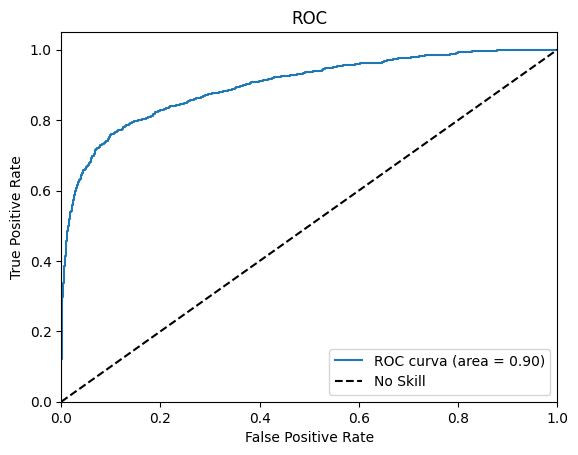

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_lgbm)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curva (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [ ]:
y_pred_lgbm_labels = (y_pred_lgbm > 0.5).astype(int)
classification_rep = classification_report(y_test_final,y_pred_lgbm_labels)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3708
           1       0.61      0.79      0.69      1021

    accuracy                           0.84      4729
   macro avg       0.77      0.83      0.79      4729
weighted avg       0.87      0.84      0.85      4729



El modelo LightGBM presenta un rendimiento inferior en comparación con el modelo base, al mostrar una mayor tasa de error en la predicción de los clientes que no cumplen con el pago oportuno de su crédito. El valor de macro average obtenido (0.79) es inferior al 0.85 del modelo base, lo que confirma su menor capacidad predictiva y precisión general.

# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/)
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](mailto:mrodrigueztr@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*